<a href="https://colab.research.google.com/github/Dannykik/ULPGL_work/blob/main/L3_work/detection_anomalie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chemin du fichier (Google Drive)
file_path = "/content/drive/MyDrive/Mon_memoire_L3/UCSD_Anomaly_Dataset.tar.gz"

# Extraire l'archive dans /content
!tar -xvzf "$file_path" -C /content

Streaming output truncated to the last 5000 lines.
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/139.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/002.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/060.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/085.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/067.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/127.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/131.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/012.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/148.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/144.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/015.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/009.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/102.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/143.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/078.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/017.bmp
UCSD_

In [ ]:
import os
os.listdir('/content')

['.config', 'UCSD_Anomaly_Dataset.v1p2', 'drive', 'sample_data']

In [ ]:
os.listdir('/content/UCSD_Anomaly_Dataset.v1p2')

['._README.txt',
 'README.txt',
 'README.txt~',
 'UCSDped1',
 'UCSDped2',
 '.DS_Store']

In [ ]:

train_path = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train'
print(os.listdir(train_path)[:5])

['Train020', 'Train002', 'Train016', 'Train019', 'Train015']


In [ ]:
test_path = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test'
print(os.listdir(test_path)[:5])

['Test025', 'Test031', 'Test019_gt', 'Test016', 'UCSDped1.m~']


#Activer le GPU (vérification)

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Charger les images (proprement)

In [ ]:
import os
import cv2
import numpy as np

IMG_SIZE = 128

def load_images_from_folder(folder):
    images = []
    for subfolder in sorted(os.listdir(folder)):
        sub_path = os.path.join(folder, subfolder)
        if os.path.isdir(sub_path):
            for file in sorted(os.listdir(sub_path)):
                if file.endswith('.tif'):
                    img_path = os.path.join(sub_path, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img = img / 255.0
                    images.append(img)
    return np.array(images)

train_folder = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train'
train_images = load_images_from_folder(train_folder)

print("Nombre d'images d'entraînement :", train_images.shape)

Nombre d'images d'entraînement : (6800, 128, 128)


#Construire l’Autoencoder CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

train_images = train_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

#Entraînement

In [ ]:
autoencoder.fit(
    train_images,
    train_images,
    epochs=10,
    batch_size=16,
    shuffle=True
)

Epoch 1/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0100
Epoch 2/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0018
Epoch 3/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0014
Epoch 4/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0011
Epoch 5/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 9.8946e-04
Epoch 6/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8.9987e-04
Epoch 7/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 8.3629e-04
Epoch 8/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 7.7858e-04
Epoch 9/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 7.3323e-04
Epoch 10/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 7.0496e-04


#Détection des anomalies

In [ ]:
test_folder = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test'
test_images = load_images_from_folder(test_folder)
test_images = test_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print("Nombre d'images de test :", test_images.shape)


Nombre d'images de test : (7200, 128, 128, 1)


#Reconstruction avec l’autoencoder

In [ ]:
reconstructed = autoencoder.predict(test_images)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


#Calculer l’erreur de reconstruction

In [ ]:
mse = np.mean(np.power(test_images - reconstructed, 2), axis=(1,2,3))

#Définir un seuil

In [ ]:
threshold = np.mean(mse) + 3*np.std(mse)
print("Seuil d'anomalie :", threshold)

Seuil d'anomalie : 0.001504586484969382


#Identifier les anomalies

In [ ]:
anomalies = mse > threshold
print("Nombre d'anomalies détectées :", np.sum(anomalies))

Nombre d'anomalies détectées : 41


#Visualiser quelques résultats

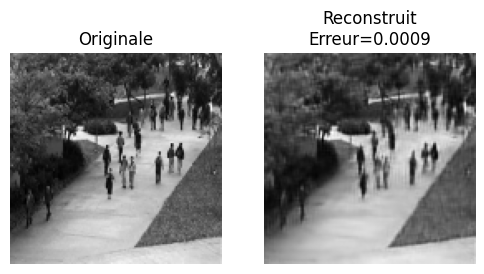

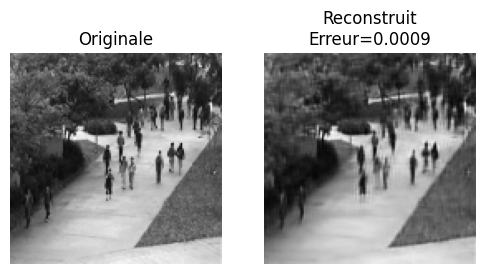

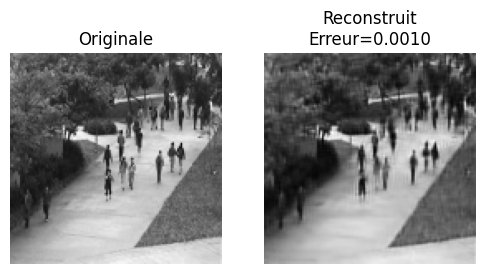

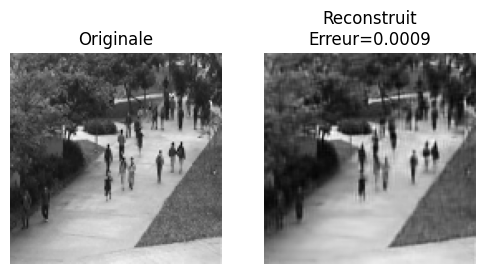

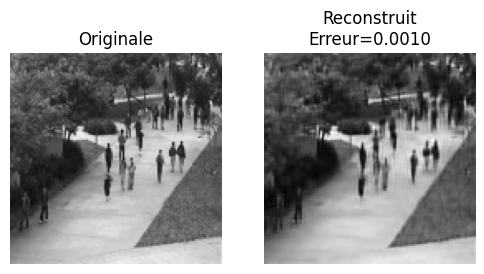

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(figsize=(6,3))
    # Image originale
    plt.subplot(1,2,1)
    plt.imshow(test_images[i].reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title("Originale")
    plt.axis('off')

    # Image reconstruite
    plt.subplot(1,2,2)
    plt.imshow(reconstructed[i].reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title(f"Reconstruit\nErreur={mse[i]:.4f}")
    plt.axis('off')

    plt.show()

In [ ]:
# Sauvegarder
autoencoder.save('/content/autoencoder_ucsd.h5')

In [ ]:
drive.mount('/content/drive')

autoencoder.save('/content/drive/MyDrive/Mon_memoire_L3/autoencoder_ucsd.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
autoencoder.save('/content/drive/MyDrive/Mon_memoire_L3/autoencoder_ucsd.h5')

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.4 MB/s eta 0:00:00
